In [1]:
!pip install evaluate rouge_score git+https://github.com/google-research/bleurt.git bert_score

  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-pdtzb1rn
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-pdtzb1rn
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install openai

In [3]:
!pip install datasets

In [4]:
!pip install evaluate nltk comet-mt unidecode

ERROR: Could not find a version that satisfies the requirement comet-mt (from versions: none)
ERROR: No matching distribution found for comet-mt


In [5]:
from datasets import load_dataset
dataset_xlcost = load_dataset("codeparrot/xlcost-text-to-code", "Python-program-level")['test']
dataset_code_x = load_dataset("google/code_x_glue_ct_code_to_text", 'python')['test']
dataset_code_search_net = load_dataset("code-search-net/code_search_net", 'python')['test']

README.md:   0%|          | 0.00/3.32k [00:00<?, ?B/s]

xlcost-text-to-code.py:   0%|          | 0.00/7.61k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/3.92M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/357k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/200k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9263 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/887 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/472 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/26.7k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/147M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/18.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/251820 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13914 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14918 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

code_search_net.py:   0%|          | 0.00/8.44k [00:00<?, ?B/s]

The repository for code-search-net/code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code-search-net/code_search_net.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


python.zip:   0%|          | 0.00/941M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [6]:
def split_text(example):
    example['text'] = example['text'].split('|')[0].strip()
    return example

dataset_xlcost = dataset_xlcost.map(split_text)

dataset_code_x = dataset_code_x.rename_column('docstring', 'text')

dataset_code_search_net = dataset_code_search_net.rename_column('func_documentation_string', 'text')
dataset_code_search_net = dataset_code_search_net.rename_column('func_code_string', 'code')

Map:   0%|          | 0/887 [00:00<?, ? examples/s]

In [15]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

In [8]:
system_message = {
      "role": "system",
      "content": "For each code snippet provided as input, output a very brief summary and nothing else. The summary must not include newline characters or full stop symbols. The number of summary outputs must exactly match the number of input code snippets, with each summary separated by the '$' symbol if there are multiple snippets"
    }

In [9]:
import os
import json

def save_to_json(dataset, summaries, references, left, right, filename):
    # Создаем список данных для сохранения
    output_data = []
    for i in range(len(references)):
        if i >= len(summaries):
            break  # Защита от расхождения длин

        sample_idx = left + i
        entry = {
            "code": dataset[sample_idx]['code'],
            "ideal_answer": references[i],
            "generated_answer": summaries[i].strip()
        }
        output_data.append(entry)

    # Создаем директорию, если она не существует
    directory = os.path.dirname(filename)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

    # Сохраняем данные в JSON
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, ensure_ascii=False, indent=2)

In [10]:
def get_summarization(model, dataset, left, right):
    codes = ""
    refs = []
    for sample in dataset.select(range(left,right)):
        codes +=sample['code'] + "\n$\n"
        refs.append(sample['text'])
    print(len(codes))
    completion = client.chat.completions.create(
        model = model,
        messages=[
          system_message,
          {
            "role": "user",
            "content": codes
          }
        ]
    )
    summary = completion.choices[0].message.content.split('$')

    return summary, refs

In [11]:
import evaluate
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
bleurt = evaluate.load("bleurt", module_type="metric", checkpoint="bleurt-base-128")
bertscore = evaluate.load("bertscore")

In [11]:
def calculate_metrics(preds, refs):
    rouge_result = rouge.compute(predictions=preds, references=refs, rouge_types=["rougeL"])["rougeL"]
    bleu_result = bleu.compute(predictions=preds, references=[[ref] for ref in refs])

    bleurt_scores = bleurt.compute(predictions=preds, references=refs)["scores"]
    avg_bleurt = sum(bleurt_scores) / len(bleurt_scores)

    bert_scores = bertscore.compute(
        predictions=preds,
        references=refs,
        lang="en",
        model_type="microsoft/deberta-large-mnli"
    )
    avg_bert_f1 = sum(bert_scores["f1"]) / len(bert_scores["f1"])


    return rouge_result, bleurt_scores, bert_scores, avg_bert_f1

In [18]:
import json
from evaluate import load
import numpy as np

# Загружаем метрики
rouge = load('rouge')
bleu = load('bleu')
bleurt = load('bleurt', checkpoint="bleurt-base-128")
bertscore = load('bertscore')
meteor = load('meteor')

def calculate_metrics_from_file(json_filename):
    with open(json_filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    references = [entry["ideal_answer"] for entry in data]
    predictions = [entry["generated_answer"] for entry in data]
    codes = [entry["code"] for entry in data]

    # --- ROUGE ---
    rouge_types = ["rouge1", "rouge2", "rougeL"]
    rouge_results = rouge.compute(predictions=predictions, references=references, rouge_types=rouge_types)

    # --- BLEU ---
    # Вычисляем BLEU для каждого примера индивидуально
    bleu_per_example = []
    for pred, ref in zip(predictions, references):
        if not pred or not ref:  # Обработка пустых строк
            bleu_per_example.append(0.0)
            continue
        result = bleu.compute(predictions=[pred], references=[[ref]])
        bleu_per_example.append(result["bleu"])

    bleu_result = np.mean(bleu_per_example)
    max_bleu = np.max(bleu_per_example)
    min_bleu = np.min(bleu_per_example)

    # --- BLEURT ---
    bleurt_scores = bleurt.compute(predictions=predictions, references=references)["scores"]
    avg_bleurt = np.mean(bleurt_scores)

    # --- BERTScore ---
    bert_scores = bertscore.compute(predictions=predictions, references=references, lang="en")
    avg_bert_precision = np.mean(bert_scores["precision"])
    avg_bert_recall = np.mean(bert_scores["recall"])
    avg_bert_f1 = np.mean(bert_scores["f1"])

    # --- METEOR ---
    meteor_scores = meteor.compute(predictions=predictions, references=references)["meteor"]

    # Собираем примеры с кодом и метриками
    examples = []
    for i in range(len(data)):
        examples.append({
            "code": codes[i],
            "ideal_answer": references[i],
            "generated_answer": predictions[i],
            "bleu": bleu_per_example[i],
            "bleurt": bleurt_scores[i],
            "bert_f1": bert_scores["f1"][i],
            "meteor": meteor_scores[i] if isinstance(meteor_scores, list) else meteor_scores
        })

    # Возвращаем результаты с детализацией
    return {
        "overall_metrics": {
            "rouge1": rouge_results["rouge1"],
            "rouge2": rouge_results["rouge2"],
            "rougeL": rouge_results["rougeL"],
            "bleu": bleu_result,
            "max_bleu": max_bleu,
            "min_bleu": min_bleu,
            "avg_bleurt": avg_bleurt,
            "avg_bert_precision": avg_bert_precision,
            "avg_bert_recall": avg_bert_recall,
            "avg_bert_f1": avg_bert_f1,
            "meteor": meteor_scores
        },
        "examples": examples
    }


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [26]:
import matplotlib.pyplot as plt

def plot_metrics_from_file(json_filename):
    results = calculate_metrics_from_file(json_filename)
    print(f"Max: {results['overall_metrics']['max_bleu']:.2f}")
    print(f"Min: {results['overall_metrics']['min_bleu']:.2f}")
    print(f"Avg: {results['overall_metrics']['bleu']:.2f}")
    print("\nExample with highest BLEU:")
    best_example = max(results["examples"], key=lambda x: x["bleu"])
    print(f"Code: {best_example['code']}")
    print(f"Ideal: {best_example['ideal_answer']}")
    print(f"Generated: {best_example['generated_answer']}")
    print(f"BLEU: {best_example['bleu']:.2f}")
    print("\n\nExample with smallest BLEU:")
    best_example = min(results["examples"], key=lambda x: x["bleu"])
    print(f"Code: {best_example['code']}")
    print(f"Ideal: {best_example['ideal_answer']}")
    print(f"Generated: {best_example['generated_answer']}")
    print(f"BLEU: {best_example['bleu']:.2f}")


    # Извлекаем все метрики из результатов
    metrics = [
        "ROUGE-1",
        "ROUGE-2",
        "ROUGE-L",
        "BLEU",
        "Avg BLEURT",
        "Avg BERTScore F1",
        "Avg BERTScore Precision",
        "Avg BERTScore Recall",
        "METEOR"
    ]
    scores = [
        results["overall_metrics"]["rouge1"],
        results["overall_metrics"]["rouge2"],
        results["overall_metrics"]["rougeL"],
        results["overall_metrics"]["bleu"],
        results["overall_metrics"]["avg_bleurt"],
        results["overall_metrics"]["avg_bert_f1"],
        results["overall_metrics"]["avg_bert_precision"],
        results["overall_metrics"]["avg_bert_recall"],
        results["overall_metrics"]["meteor"]
    ]

    # Разделяем метрики по типам для цветового кодирования
    rouge_metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
    bert_metrics = ["Avg BERTScore F1", "Avg BERTScore Precision", "Avg BERTScore Recall"]
    other_metrics = ["BLEU", "Avg BLEURT", "METEOR"]

    # Создаем цветовую схему
    colors = []
    for metric in metrics:
        if metric in rouge_metrics:
            colors.append('lightcoral')
        elif metric in bert_metrics:
            colors.append('lightskyblue')
        else:
            colors.append('skyblue')

    # Создаем график
    plt.figure(figsize=(16, 7))
    bars = plt.bar(metrics, scores, color=colors, edgecolor='black')

    # Поворот меток оси X
    plt.xticks(rotation=45, ha='right')

    # Настройка графика
    plt.title(f"All Metrics for {json_filename}", fontsize=16)
    plt.xlabel("Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)

    # Автоматические пределы по оси Y
    ymin = min(scores) - 0.1
    ymax = max(scores) + 0.1
    plt.ylim(ymin, ymax)

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Добавляем значения над столбцами
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f"{score:.2f}",
            ha='center',
            fontsize=11
        )

    # Легенда
    rouge_patch = plt.Line2D([0], [0], color='lightcoral', lw=4, label='ROUGE Metrics')
    bert_patch = plt.Line2D([0], [0], color='lightskyblue', lw=4, label='BERTScore Metrics')
    other_patch = plt.Line2D([0], [0], color='skyblue', lw=4, label='Other Metrics')

    plt.legend(
        handles=[rouge_patch, bert_patch, other_patch],
        loc='upper right',
        fontsize=11,
        frameon=True,
        shadow=True
    )

    plt.tight_layout()
    plt.show()

12771
Max: 0.41
Min: 0.00
Avg: 0.03

Example with highest BLEU:
Code: import sys NEW_LINE Landau = - sys . maxsize - 1 NEW_LINE def gcd ( a , b ) : NEW_LINE INDENT if ( a == 0 ) : NEW_LINE INDENT return b NEW_LINE DEDENT return gcd ( b % a , a ) NEW_LINE DEDENT def lcm ( a , b ) : NEW_LINE INDENT return ( a * b ) // gcd ( a , b ) NEW_LINE DEDENT def findLCM ( arr ) : NEW_LINE INDENT global Landau NEW_LINE nth_lcm = arr [ 0 ] NEW_LINE for i in range ( 1 , len ( arr ) ) : NEW_LINE INDENT nth_lcm = lcm ( nth_lcm , arr [ i ] ) NEW_LINE DEDENT Landau = max ( Landau , nth_lcm ) NEW_LINE DEDENT def findWays ( arr , i , n ) : NEW_LINE INDENT if ( n == 0 ) : NEW_LINE INDENT findLCM ( arr ) NEW_LINE DEDENT for j in range ( i , n + 1 ) : NEW_LINE INDENT arr . append ( j ) NEW_LINE findWays ( arr , j , n - j ) NEW_LINE arr . pop ( ) NEW_LINE DEDENT DEDENT def Landau_function ( n ) : NEW_LINE INDENT arr = [ ] NEW_LINE findWays ( arr , 1 , n ) NEW_LINE print ( Landau ) NEW_LINE DEDENT N = 4 NEW_LINE

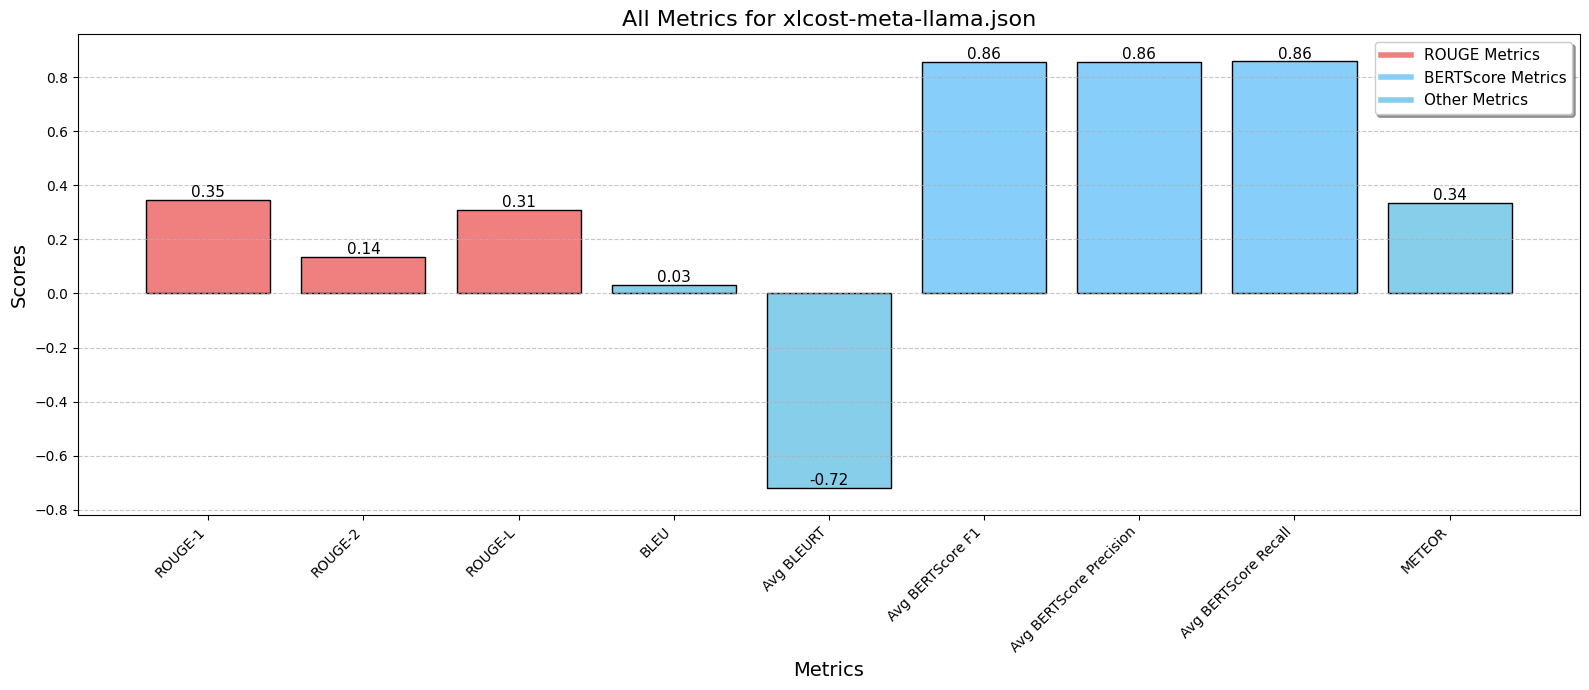

In [27]:
preds, refs = get_summarization("meta-llama/llama-4-maverick:free", dataset_xlcost, 0, 20)
if len(preds)>len(refs):
    preds = preds[:len(refs)]
save_to_json(dataset_xlcost, preds, refs, 0, 20, "xlcost-meta-llama.json")
plot_metrics_from_file("xlcost-meta-llama.json")
# res = calculate_metrics_from_file("xlcost-meta-llama.json")


In [ ]:
preds, refs = get_summarization("deepseek/deepseek-chat-v3-0324:free", dataset_code_x , 0, 100)
rouge_result, bleurt_scores, bert_scores, avg_bert_f1 = calculate_metrics(preds,refs)

print("\rouge_result:", rouge_result)
print("bleurt_scores:", bleurt_scores)
print(f"bert_scores:", bert_scores)
print(f"avg_bert_f1 F1", avg_bert_f1)


In [ ]:
preds, refs = get_summarization("deepseek/deepseek-chat-v3-0324:free", dataset_code_search_net , 0, 100)
rouge_result, bleurt_scores, bert_scores, avg_bert_f1 = calculate_metrics(preds,refs)

print("\rouge_result:", rouge_result)
print("bleurt_scores:", bleurt_scores)
print(f"bert_scores:", bert_scores)
print(f"avg_bert_f1 F1", avg_bert_f1)
